IoU for the road class: 0.037318032201672555


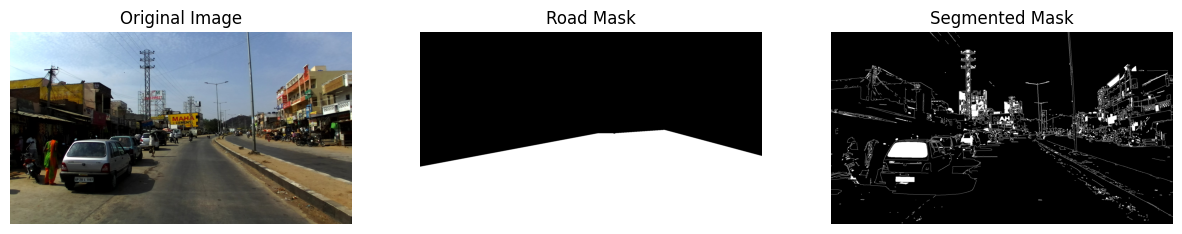

In [4]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def process_image_and_json(image_path, json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    road_polygon = None
    for obj in data['objects']:
        if obj['label'] == 'road':
            road_polygon = np.array(obj['polygon'], dtype=np.int32)
            break

    if road_polygon is None:
        return None, None, None, None

    road_mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    cv2.fillPoly(road_mask, [road_polygon], 255)

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Create a binary mask from the edges
    canny_mask = np.zeros_like(edges)
    canny_mask[edges > 0] = 255

    # Fill the regions inside the edges to create a segmented mask
    contours, _ = cv2.findContours(canny_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_mask = np.zeros_like(canny_mask)
    cv2.drawContours(segmented_mask, contours, -1, (255), thickness=cv2.FILLED)


    iou = calculate_iou(road_mask, segmented_mask)
    return img, road_mask, segmented_mask, iou

# Paths to the image and JSON file
image_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\leftImg8bit\train\201\frame0029_leftImg8bit.jpg'
json_path = r'E:\Projects\Finished\Semantic Segmentation\idd20kII\gtFine\train\201\frame0029_gtFine_polygons.json'

img, road_mask, segmented_mask, iou = process_image_and_json(image_path, json_path)
if iou is not None:
    print(f"IoU for the road class: {iou}")

    # Display the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(road_mask, cmap='gray')
    axs[1].set_title('Road Mask')
    axs[1].axis('off')

    axs[2].imshow(segmented_mask, cmap='gray')
    axs[2].set_title('Segmented Mask')
    axs[2].axis('off')

    plt.show()
else:
    print("Road class not found in the JSON file.")